In [3]:
# Install required packages
# pip install pyspark matplotlib seaborn pandas numpy

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
# 1. Initialize Spark
spark = SparkSession.builder.appName("BreastCancer").getOrCreate()

In [5]:
# 2. Load data (using built-in dataset)
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer()
pdf = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
pdf['diagnosis'] = cancer_data.target
df = spark.createDataFrame(pdf)

In [6]:
# 3. Basic info
print("Data shape:", df.count(), "x", len(df.columns))
df.groupBy("diagnosis").count().show()

Data shape: 569 x 31
+---------+-----+
|diagnosis|count|
+---------+-----+
|        0|  212|
|        1|  357|
+---------+-----+



In [7]:
# 4. Prepare features
feature_cols = [c for c in df.columns if c != 'diagnosis']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(df)

In [8]:
# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
df_scaled = scaler.fit(df_assembled).transform(df_assembled)

In [9]:
# 5. Split and train
train, test = df_scaled.randomSplit([0.7, 0.3])
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="diagnosis")
model = lr.fit(train)

In [10]:
# 6. Predict and evaluate
predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="diagnosis")
auc = evaluator.evaluate(predictions)
print(f"Model AUC: {auc:.4f}")

Model AUC: 0.9972


In [11]:
# 7. Simple visualization
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

Text(0.5, 1.0, 'Class Distribution')

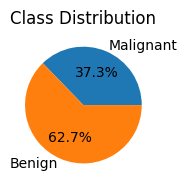

In [12]:
# Plot 1: Class distribution
plt.subplot(1, 3, 1)
class_dist = df.groupBy("diagnosis").count().toPandas()
plt.pie(class_dist['count'], labels=['Malignant', 'Benign'], autopct='%1.1f%%')
plt.title('Class Distribution')

Text(0.5, 1.0, 'Feature Correlation')

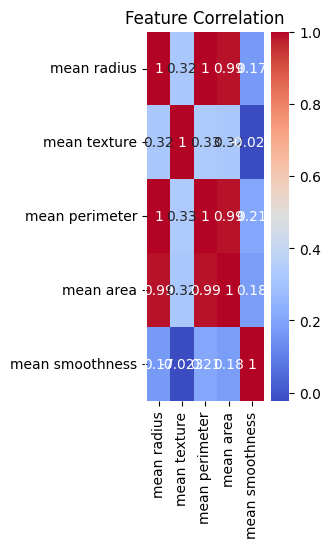

In [13]:
# Plot 2: Feature correlation
plt.subplot(1, 3, 2)
corr_data = df.select(feature_cols[:5]).toPandas().corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm')
plt.title('Feature Correlation')

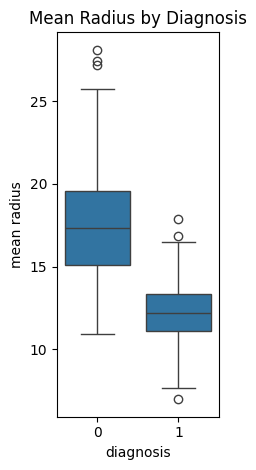

In [14]:
# Plot 3: Mean radius distribution
plt.subplot(1, 3, 3)
radius_data = df.select('mean radius', 'diagnosis').toPandas()
sns.boxplot(data=radius_data, x='diagnosis', y='mean radius')
plt.title('Mean Radius by Diagnosis')

plt.tight_layout()
plt.show()


In [15]:
# 8. Stop Spark
spark.stop()